In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os
from ipywidgets import interact, FloatSlider

%matplotlib widget

In [2]:
def plot(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Benchmarks

[1.950e-03 2.930e-03 3.910e-03 5.860e-03 7.810e-03 1.172e-02 1.562e-02
 2.344e-02 3.125e-02 4.688e-02 6.250e-02 9.375e-02 1.250e-01 1.875e-01
 2.500e-01 3.750e-01 5.000e-01 7.500e-01 1.000e+00 1.500e+00 2.000e+00
 3.000e+00 4.000e+00 6.000e+00 8.000e+00 1.200e+01 1.600e+01 2.400e+01
 3.200e+01 4.800e+01 6.400e+01 9.600e+01 1.280e+02 1.920e+02 2.560e+02
 3.840e+02 5.120e+02 7.680e+02 1.024e+03 1.536e+03 2.048e+03]
[ 1.25966667  1.26033333  1.25933333  1.25933333  1.271       1.271
  1.26066667  1.26933333  1.26833333  4.424       4.424       4.42233333
  4.422       4.42066667  4.42533333  5.253       5.27066667  6.40666667
  9.15166667 18.905      20.99766667 20.848      20.783      20.69966667
 20.97333333 21.139      20.97433333 26.876      40.04066667 53.22766667
 57.831      57.20566667 58.32266667 61.76966667 66.36066667 61.348
 61.33933333 62.53533333 62.40733333 63.363      62.77633333]


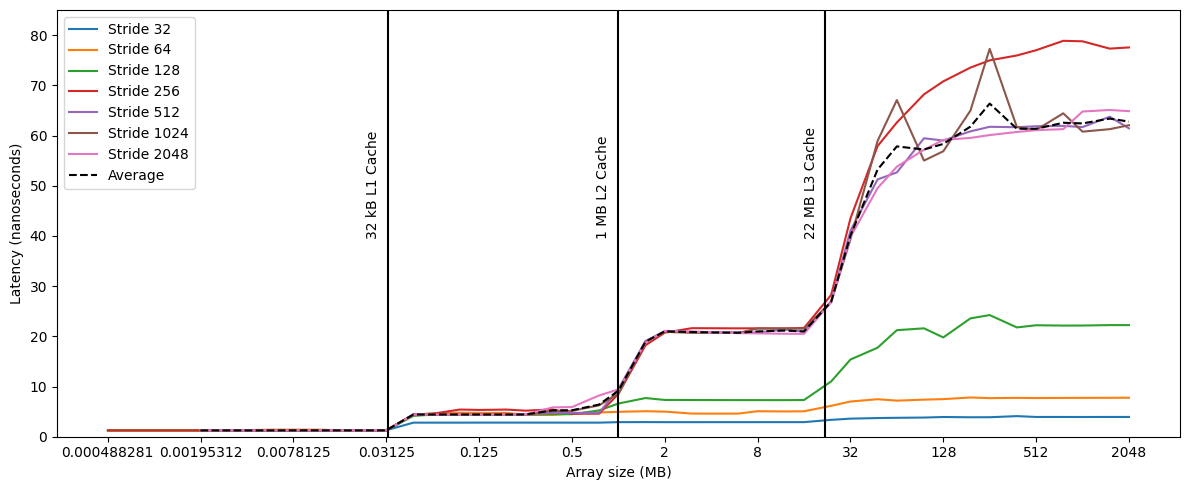

In [3]:
# Initialize an empty dictionary to hold the data for each stride
data = {}

# Open the file and read the data
with open('mem_lat.out', 'r') as f:
    stride = None
    for line in f:
        # Check if this line indicates a new stride
        if line.startswith('"stride='):
            # Extract the stride value
            stride = int(line.split('=')[1])
            # Initialize a new list for this stride
            data[stride] = []
        elif line == '\n':
            # Stride is done, reset it
            stride = None
        elif stride is not None:
            # This line contains data for the current stride
            array_size, latency = map(float, line.split())
            data[stride].append((array_size, latency))

plt.figure(figsize=(12, 5))
ax = plt.subplot(111)

# Plot the data for each stride
for stride, values in data.items():
    # Separate the data into two lists for plotting
    array_sizes, latencies = zip(*values)
    # Plot this stride's data
    plt.plot(array_sizes, latencies, label=f'Stride {stride}')

# Get averages the total average time for the strides 512, 1024 and 2048
results = []
for stride, values in data.items():
    if stride in [512, 1024, 2048]:
        results.append(values)

results = [list(zip(*x)) for x in results]
averages = np.mean([list(x[1]) for x in results], axis=0)
print(np.array(results[0][0]))
print(averages)
plt.plot(results[0][0], averages, label="Average", color="k", linestyle="--")

plt.ylabel("Latency (nanoseconds)")
plt.xlabel("Array size (MB)")
plt.xscale("log", base=2)
# plt.xticks(results[0,:,0],results[0,:,0], rotation=45)
plt.xticks([2**i for i in range(-10,12)])
locmaj = matplotlib.ticker.LogLocator(base=2,numticks=21)
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(0, 2000, 0.1))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ymax=85
texty=40
plt.vlines([0.032, 1, 22], 0, ymax, color="k")
plt.text(0.023, texty, "32 kB L1 Cache", rotation=90)
plt.text(.72, texty, "1 MB L2 Cache", rotation=90)
plt.text(16, texty, "22 MB L3 Cache", rotation=90)
plt.axis(ymin=0, ymax=ymax)
plt.legend()
plt.tight_layout()
plt.savefig("mem_lat.pdf")

# Show the plot
plt.show()

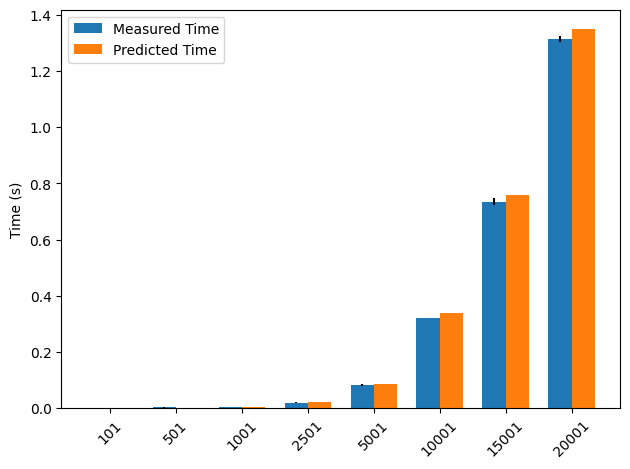

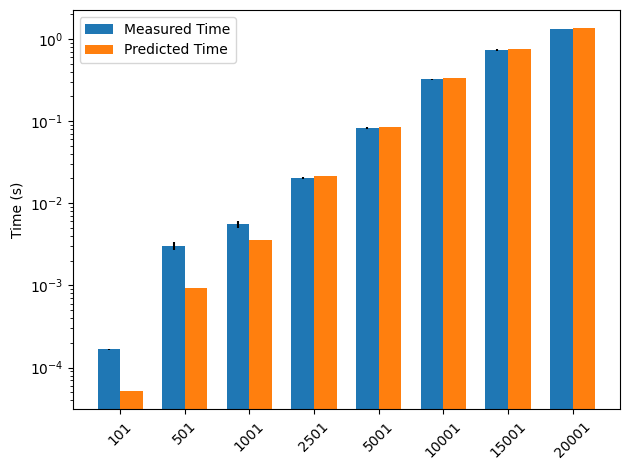

In [18]:
def visualize_csv(filename, log=False):
    df = pd.read_csv(filename)
    df = df.sort_values('nodes')

    fig, ax = plt.subplots()
    bar_width = 0.35

    index = np.arange(len(df['nodes'].unique()))
    averages = df.groupby('nodes')['measured_time'].mean()
    errors = df.groupby('nodes')['measured_time'].std()
    predicted = df.groupby('nodes')['predicted_time'].mean()
    predicted_errors = df.groupby('nodes')['predicted_time'].std()

    ax.bar(index, averages, bar_width, yerr=errors, label='Measured Time')
    ax.bar(index + bar_width, predicted, bar_width, yerr=predicted_errors, label='Predicted Time')

    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df['nodes'].unique(), rotation=45)
    ax.set_ylabel('Time (s)')
    if log:
        ax.set_yscale('log')
    ax.legend()

    plt.tight_layout()
    plt.savefig(filename.split('.')[0] + ('_log' if log else '') + '.png')
    plt.show()

    return df

visualize_csv('bfs_benchmark_star.csv', False)
df_gb_sw = visualize_csv('bfs_benchmark_star.csv', True)

Relative differences: nodes
101      68.941591
501      69.305013
1001     35.857954
2501      5.843878
5001      3.957950
10001     5.465341
15001     3.436413
20001     2.752532
dtype: float64


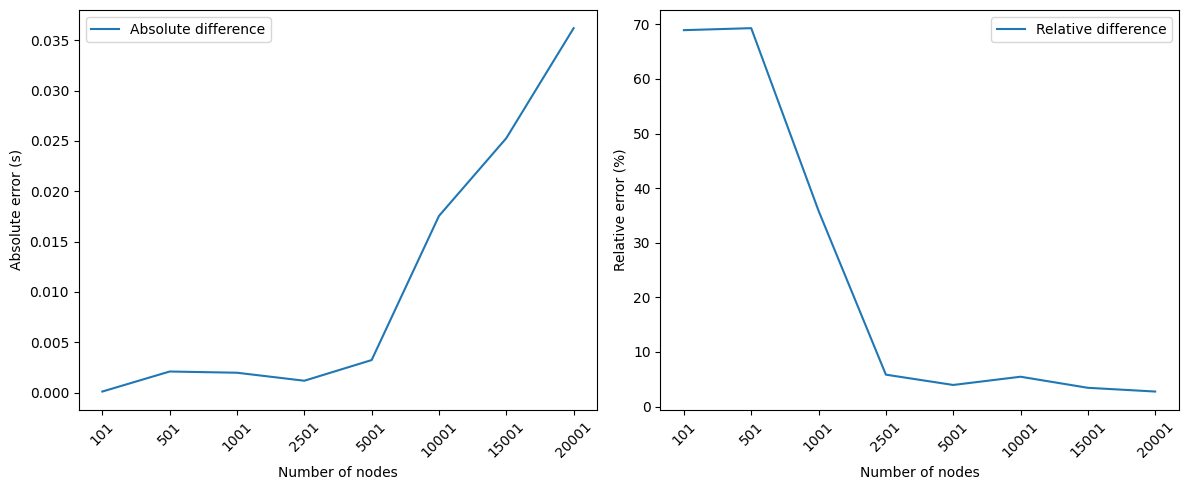

In [17]:
index = np.arange(len(df_gb_sw['nodes'].unique()))
averages = df_gb_sw.groupby('nodes')['measured_time'].mean()
predicted = df_gb_sw.groupby('nodes')['predicted_time'].mean()

# Get the absolute and relative differences between the measured and predicted times
absolute_diff = abs(averages - predicted)
relative_diff = absolute_diff / averages * 100

# print("Absolute differences:", absolute_diff)
print("Relative differences:", relative_diff)

# For each number of nodes, get also the number of edges
edges = df_gb_sw.groupby('nodes')['edges'].mean()
# Add a column to the dataframe with the number of edges divided by the number of nodes
df_gb_sw['edges_per_node'] = df_gb_sw['edges'] / df_gb_sw['nodes']
df_gb_sw.groupby('nodes')['edges_per_node'].mean()

# Plot absolute and relative errors in subplots horizontally
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(index, absolute_diff, label='Absolute difference')
ax[0].set_ylabel('Absolute error (s)')
ax[0].set_xlabel('Number of nodes')
ax[0].set_xticks(index)
ax[0].set_xticklabels(df_gb_sw['nodes'].unique(), rotation=45)
ax[0].legend()

ax[1].plot(index, relative_diff, label='Relative difference')
ax[1].set_ylabel('Relative error (%)')
ax[1].set_xlabel('Number of nodes')
ax[1].set_xticks(index)
ax[1].set_xticklabels(df_gb_sw['nodes'].unique(), rotation=45)
ax[1].legend()

plt.tight_layout()
plt.savefig('bfs_benchmark_star_errors.pdf')
plt.show()


Two tests: remove level check, and remove G[u][v] > 0 check

# Betweenness Centrality

### Dijkstra statistical model

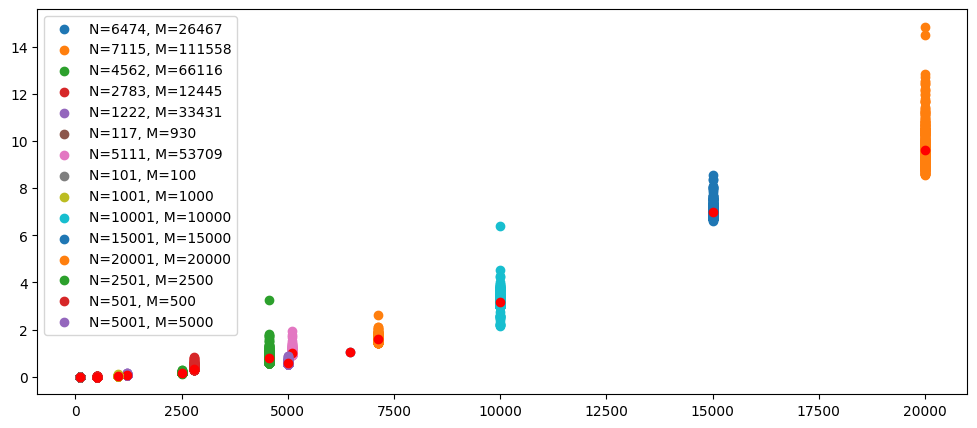

In [8]:
%matplotlib inline
def plot_benchmark(mtx_path, csv_path):
    for filename in os.listdir(mtx_path):
        if filename.endswith('.mtx'):
            # Open mtx file and read the number of nodes and edges
            mtx = open(os.path.join(mtx_path, filename), 'r')
            lines = mtx.readlines()
            num_nodes = int(lines[1].split()[1])
            num_edges = int(lines[1].split()[2])
            mtx.close()

            # Open the corresponding csv file and read the data
            csv = pd.read_csv(os.path.join(csv_path, filename.split('.')[0] + '.csv'))
            plt.scatter(np.repeat(num_nodes, len(csv['time'])), csv['time'], label=f'N={num_nodes}, M={num_edges}')
            plt.scatter(num_nodes, csv['time'].mean(), color='red')

plt.figure(figsize=(12, 5))

plot_benchmark('../../data/single_cc/', './')
plot_benchmark('../../data/single_cc/star_graphs/', './')

# plt.yscale('log')
plt.legend()
plt.show()

# Pagerank

In [4]:
hardware_DAS6 = {
    "hosts": [{
        "id": 1,
        "name": "host1",
        "cpus": {
            "id": 1,
            "name": "intel xeon",
            "clock_speed": 2.10,
            "cores": 16,
            "threads": 32,
            "wattage": 35,
            "amount": 2,
            "benchmarks": {
                "T_int_add": 0.5578617,
                "T_int_mult": 0.4184611,
                "T_int_gt": 0.1744996,
                "T_int_neq": 0.5478698,
                "T_float_add": 1.224059,
                "T_float_sub": 0.5994229,
                "T_float_mult": 1.049776,
                "T_float_div": 1.497595,
                "T_float_gt": 0.09373358,
                "T_q_push": 17.31605,
                "T_q_front": 13.004,
                "T_q_pop": 10.86569,
                "T_heap_insert_max": 35.76752,
                "T_heap_extract_min": 91.92505,
                "T_heap_decrease_key": 10.23379,
                "T_push_back": 15.33078,
                "L1_linesize": 64,
                "L2_linesize": 64,
                "L3_linesize": 64,
                "T_L1_read": 1.26,
                "T_L2_read": 4.24,
                "T_L3_read": 20.9,
                "T_DRAM_read": 62.5
                }
            }
        }
    ]
}

import sys
sys.path.insert(0, os.path.abspath(r"C:\Users\BartD\Documents\PhD\shared_VM\graph-optimizer"))
from models.pagerank.performance_model import predict as predict_pr
from models.evaluate_model import evaluate

def perf_model(hw, n,m, T_write):
    return evaluate(predict_pr(hw["hosts"][0]), {'n': n, 'm': m, 'T_mem_write': T_write})

In [5]:
def csv_to_df(filename, exclude_low=False):
    df = pd.read_csv(filename)
    df = df.sort_values('G.SIZE_VERTS')
    df_small = df[(df['G.SIZE_VERTS'] < 30000) & (df['G.SIZE_VERTS'] > 1000)]
    df_small = df_small.groupby('G.SIZE_VERTS').apply(lambda x: x[x['runtime_ns'] != x['runtime_ns'].max()])
    return df_small

df_seq_sw = csv_to_df('pagerank/output_seq_random_sw.csv')
df_seq_sw_O0 = csv_to_df('pagerank/output_seq_random_sw_O0.csv')
df_seq_gnm = csv_to_df('pagerank/output_seq_random_gnm.csv')
df_seq_gnm_O0 = csv_to_df('pagerank/output_seq_random_gnm_O0.csv')
df_seq_konect = csv_to_df('pagerank/output_seq_konect.csv')

def render_prediction(T_write):
    # For each graph, get the predicted runtime using G.SIZE_VERTS and G.SIZE_EDGES
    df_seq_sw['predicted_time'] = df_seq_sw.apply(lambda x: perf_model(hardware_DAS6, x['G.SIZE_VERTS'], x['G.SIZE_EDGES'], T_write), axis=1)

    # Plot with runtime on y axis and number of nodes on x axis
    plt.figure(figsize=(12, 5))
    plt.scatter(df_seq_sw['G.SIZE_VERTS'], df_seq_sw['runtime_ns'], label='Small world')
    plt.scatter(df_seq_sw_O0['G.SIZE_VERTS'], df_seq_sw_O0['runtime_ns'], label='Small world -O0')
    plt.scatter(df_seq_gnm['G.SIZE_VERTS'], df_seq_gnm['runtime_ns'], label='Erdos-Renyi')
    plt.scatter(df_seq_gnm_O0['G.SIZE_VERTS'], df_seq_gnm_O0['runtime_ns'], label='Erdos-Renyi -O0')
    plt.plot(df_seq_sw['G.SIZE_VERTS'], df_seq_sw['predicted_time'], color='red', label='Predicted time')
    plt.xlabel('Number of nodes')
    plt.ylabel('Runtime (ns)')
    plt.title('Standard sequential PageRank on DAS-6')
    plt.legend()
    plt.show()


interact(render_prediction, T_write=FloatSlider(min=0, max=10000, step=1, description='T_write', value=0));

interactive(children=(FloatSlider(value=0.0, description='T_write', max=10000.0, step=1.0), Output()), _dom_cl…

In [7]:
hardware_DAS5 = {
    "hosts": [{
        "id": 1,
        "name": "host1",
        "cpus": {
            "id": 1,
            "name": "intel xeon",
            "clock_speed": 2.10,
            "cores": 16,
            "threads": 32,
            "wattage": 35,
            "amount": 2,
            "benchmarks": {
                'T_int_add': 0.4571082, 'T_int_mult': 0.3855319, 'T_int_gt': 0.09951253, 'T_int_neq': 0.3146975,
                'T_float_add': 0.9419077, 'T_float_sub': 0.9903419, 'T_float_mult': 0.7076922, 'T_float_div': 4.431032, 'T_float_gt': 0.09946581,
                'T_q_push': 16.1175, 'T_q_front': 16.07651, 'T_q_pop': 11.76532,
                'T_heap_insert_max': 48.84988, 'T_heap_extract_min': 118.7842, 'T_heap_decrease_key': 13.20088,
                'T_push_back': 13.9929,
                'L1_linesize': 64, 'L2_linesize': 64, 'L3_linesize': 64,
                'T_L1_read': 1, 'T_L2_read': 4, 'T_L3_read': 14, 'T_DRAM_read': 94}
            }
        }
    ]
}

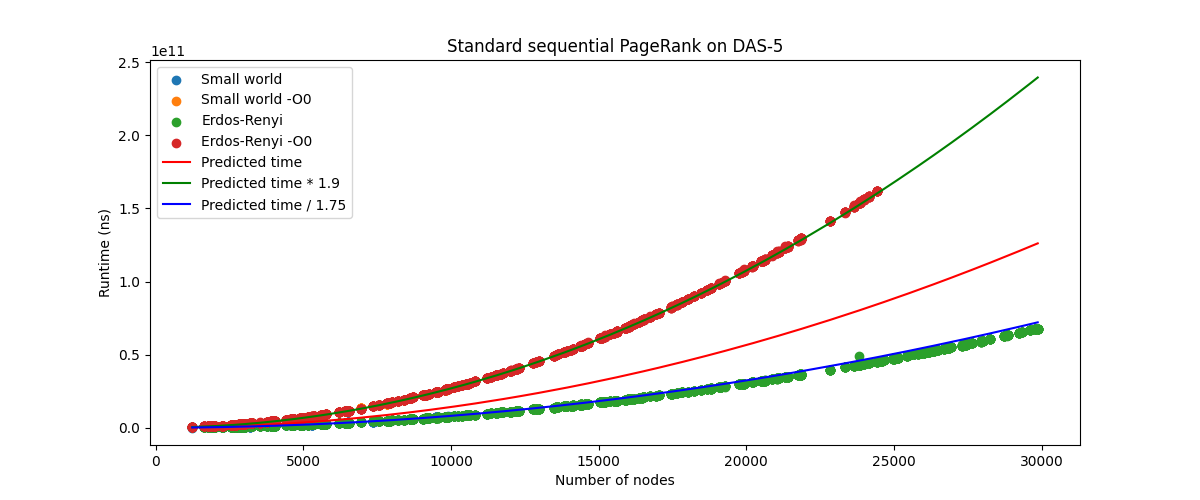

In [8]:
df_seq_sw = csv_to_df('pagerank/output_seq_sw_das5_O3.csv')
df_seq_sw_O0 = csv_to_df('pagerank/output_seq_sw_das5_O0.csv')
df_seq_gnm = csv_to_df('pagerank/output_seq_gnm_das5_O3.csv')
df_seq_gnm_O0 = csv_to_df('pagerank/output_seq_gnm_das5_O0.csv')

# For each graph, get the predicted runtime using G.SIZE_VERTS and G.SIZE_EDGES
df_seq_gnm['predicted_time'] = df_seq_gnm.apply(lambda x: perf_model(hardware_DAS5, x['G.SIZE_VERTS'], x['G.SIZE_EDGES']), axis=1)

# Plot with runtime on y axis and number of nodes on x axis
plt.figure(figsize=(12, 5))
plt.scatter(df_seq_sw['G.SIZE_VERTS'], df_seq_sw['runtime_ns'], label='Small world')
plt.scatter(df_seq_sw_O0['G.SIZE_VERTS'], df_seq_sw_O0['runtime_ns'], label='Small world -O0')
plt.scatter(df_seq_gnm['G.SIZE_VERTS'], df_seq_gnm['runtime_ns'], label='Erdos-Renyi')
plt.scatter(df_seq_gnm_O0['G.SIZE_VERTS'], df_seq_gnm_O0['runtime_ns'], label='Erdos-Renyi -O0')
plt.plot(df_seq_gnm['G.SIZE_VERTS'], df_seq_gnm['predicted_time'], color='red', label='Predicted time')

plt.plot(df_seq_gnm['G.SIZE_VERTS'], df_seq_gnm['predicted_time'] * 1.9, color='green', label='Predicted time * 1.9')
plt.plot(df_seq_gnm['G.SIZE_VERTS'], df_seq_gnm['predicted_time'] /1.75, color='blue', label='Predicted time / 1.75')
plot('Standard sequential PageRank on DAS-5', 'Number of nodes', 'Runtime (ns)')

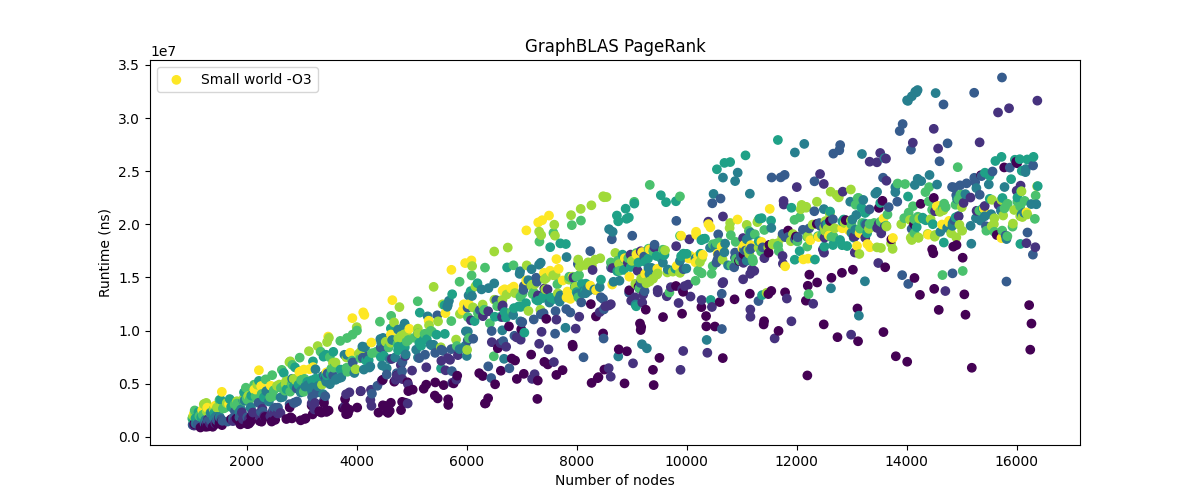

In [67]:
df_sw_10k = csv_to_df('pagerank/output_gb_sw_10000_iter.csv')
df_gnm_10k = csv_to_df('pagerank/output_gb_gnm_10000_iter.csv')
df_sw_O3 = csv_to_df('pagerank/output_gb_random_sw.csv')
df_gnm_O3 = csv_to_df('pagerank/output_gb_random_gnm.csv')
df_sw_O0 = csv_to_df('pagerank/output_gb_sw_das6_O0.csv')
df_gnm_O0 = csv_to_df('pagerank/output_gb_gnm_das6_O0.csv')

# Take the average runtime for each graph
df_sw_O3 = df_sw_O3.groupby('graph').mean('runtime_ns').reset_index()
df_gnm_O3 = df_gnm_O3.groupby('graph').mean('runtime_ns').reset_index()

# Calculate average degree for each graph
df_sw_O3['k'] = df_sw_O3['G.SIZE_EDGES'] / df_sw_O3['G.SIZE_VERTS']
df_gnm_O3['k'] = df_gnm_O3['G.SIZE_EDGES'] / df_gnm_O3['G.SIZE_VERTS']

# Plot with runtime on y axis and number of nodes on x axis
plt.figure(figsize=(12, 5))
plt.scatter(df_sw_O3['G.SIZE_VERTS'], df_sw_O3['runtime_ns'], c=df_sw_O3['k'], label='Small world -O3')
# plt.scatter(df_gnm_O3['G.SIZE_VERTS'], df_gnm_O3['runtime_ns'], c=df_gnm_O3['k'], label='Erdos-Renyi -O3')
# plt.scatter(df_sw_10k['G.SIZE_VERTS'], df_sw_10k['runtime_ns'] / 100, label='Small world 10k iter')
# plt.scatter(df_gnm_10k['G.SIZE_VERTS'], df_gnm_10k['runtime_ns'] / 100, label='Erdos-Renyi 10k iter')
# plt.scatter(df_sw_O0['G.SIZE_VERTS'], df_sw_O0['runtime_ns'], label='Small world -O0')
# plt.scatter(df_gnm_O0['G.SIZE_VERTS'], df_gnm_O0['runtime_ns'], label='Erdos-Renyi -O0')
plot('GraphBLAS PageRank', 'Number of nodes', 'Runtime (ns)')

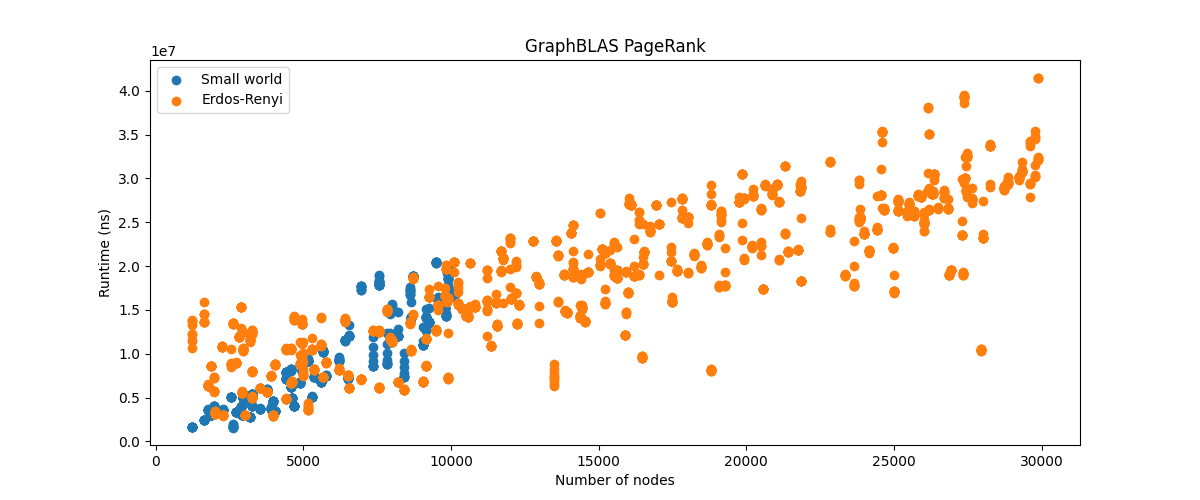

In [63]:
df_gb_sw_das5 = csv_to_df('pagerank/output_gb_sw_das5_O3.csv')
df_gb_gnm_das5 = csv_to_df('pagerank/output_gb_gnm_das5_O3.csv')
# df_gb_seq_konect = csv_to_df('pagerank/output_gb_konect.csv')

# Plot with runtime on y axis and number of nodes on x axis
plt.figure(figsize=(12, 5))
plt.scatter(df_gb_sw_das5['G.SIZE_VERTS'], df_gb_sw_das5['runtime_ns'], label='Small world')
plt.scatter(df_gb_gnm_das5['G.SIZE_VERTS'], df_gb_gnm_das5['runtime_ns'], label='Erdos-Renyi')
# plt.scatter(df_gb_seq_konect['G.SIZE_VERTS'], df_gb_seq_konect['runtime_ns'], label='Konect')
plt.xlabel('Number of nodes')
plt.ylabel('Runtime (ns)')
plt.title('GraphBLAS PageRank')
plt.legend()
plt.show()

## Topology

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


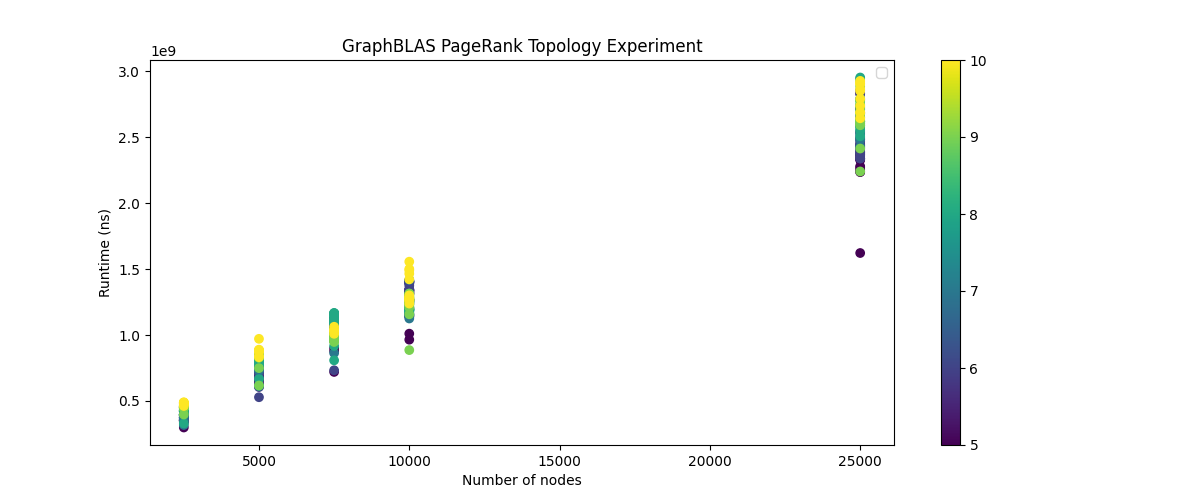

In [49]:
df_sw_topo = csv_to_df('pagerank/output_gb_sw_10000_iter_topo.csv')
df_gnm_topo = csv_to_df('pagerank/output_gb_gnm_10000_iter_topo.csv')

# For each graph, take the avarage measurement for runtime_ns
df_sw_topo = df_sw_topo.groupby('graph').mean('runtime_ns').reset_index()

# Extract k and p from the name of the graph
df_sw_topo['k'] = df_sw_topo['graph'].apply(lambda x: int(x.split('_')[2]))
df_sw_topo['derived_k'] = df_sw_topo['G.SIZE_EDGES'] / df_sw_topo['G.SIZE_VERTS']
df_sw_topo['p'] = df_sw_topo['graph'].apply(lambda x: float(x.split('_')[3][:-4]))

# Plot with runtime on y axis and number of nodes on x axis
plt.figure(figsize=(12, 5))
plt.scatter(df_sw_topo['G.SIZE_VERTS'], df_sw_topo['runtime_ns'], c=df_sw_topo['derived_k'])
plt.colorbar()
plot('GraphBLAS PageRank Topology Experiment', 'Number of nodes', 'Runtime (ns)')

# Breadth First Search

## Naive

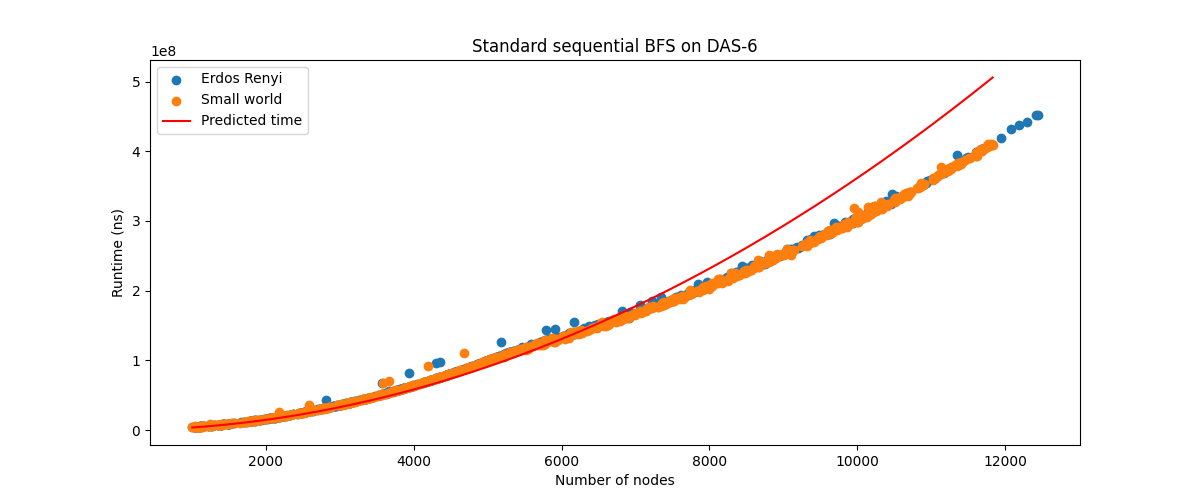

In [42]:
from models.bfs.performance_model import predict as predict_bfs

def bfs_model(hw, n):
    return evaluate(predict_bfs(hw["hosts"][0]), {'n': n})

bfs_naive_gnm = csv_to_df('bfs/autobench/naive_O0/gnm/output_single_cc.csv')
bfs_naive_sw = csv_to_df('bfs/autobench/naive_O0/sw/output_single_cc.csv')

# Take the average per graph
bfs_naive_gnm = bfs_naive_gnm.groupby('graph').mean('runtime_ns').reset_index()
bfs_naive_sw = bfs_naive_sw.groupby('graph').mean('runtime_ns').reset_index()

# For each graph, get the predicted runtime using G.SIZE_VERTS and G.SIZE_EDGES
bfs_naive_sw['predicted_time'] = bfs_naive_sw.apply(lambda x: bfs_model(hardware_DAS6, x['G.SIZE_VERTS']), axis=1)

# Sort graphs by size
bfs_naive_sw = bfs_naive_sw.sort_values('G.SIZE_VERTS')

# Plot with runtime on y axis and number of nodes on x axis
fig = plt.figure(figsize=(12, 5))
plt.scatter(bfs_naive_gnm['G.SIZE_VERTS'], bfs_naive_gnm['runtime_ns'], label='Erdos Renyi')
plt.scatter(bfs_naive_sw['G.SIZE_VERTS'], bfs_naive_sw['runtime_ns'], label='Small world')
plt.plot(bfs_naive_sw['G.SIZE_VERTS'], bfs_naive_sw['predicted_time'] * 1000000, color='red', label='Predicted time')

plot('Standard sequential BFS on DAS-6', 'Number of nodes', 'Runtime (ns)')

## GraphBLAS

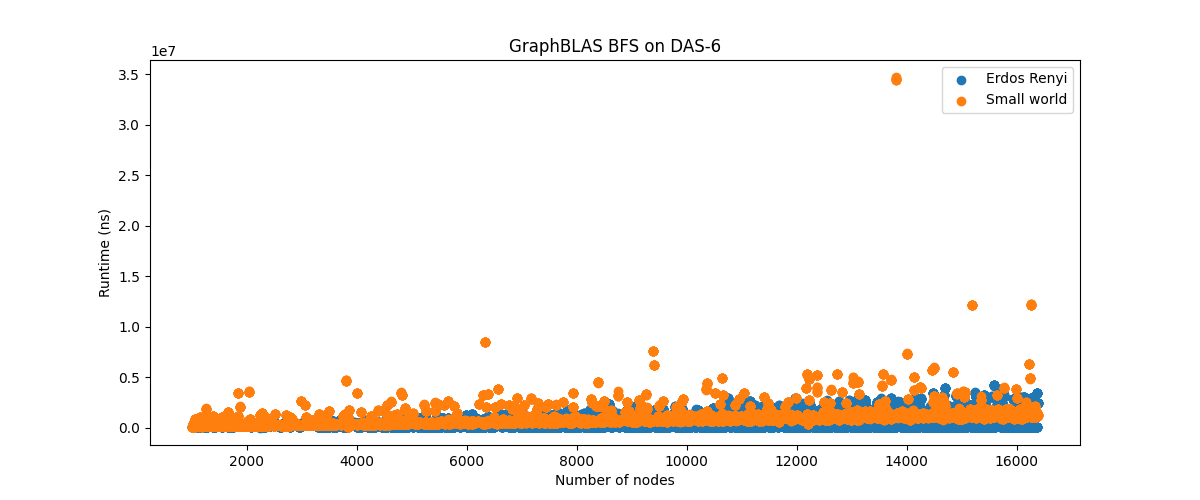

In [44]:
bfs_gb_gnm = csv_to_df('bfs/autobench/gb/gnm/output.csv')
bfs_gb_sw = csv_to_df('bfs/autobench/gb/sw/output.csv')

# Take the average per graph
# bfs_naive_gnm = bfs_naive_gnm.groupby('graph').mean('runtime_ns').reset_index()
# bfs_naive_sw = bfs_naive_sw.groupby('graph').mean('runtime_ns').reset_index()

# For each graph, get the predicted runtime using G.SIZE_VERTS and G.SIZE_EDGES
# bfs_naive_gnm['predicted_time'] = bfs_naive_gnm.apply(lambda x: bfs_model(hardware_DAS6, x['G.SIZE_VERTS']), axis=1)

# Plot with runtime on y axis and number of nodes on x axis
plt.figure(figsize=(12, 5))
plt.scatter(bfs_gb_gnm['G.SIZE_VERTS'], bfs_gb_gnm['runtime_ns'], label='Erdos Renyi')
plt.scatter(bfs_gb_sw['G.SIZE_VERTS'], bfs_gb_sw['runtime_ns'], label='Small world')

plot("GraphBLAS BFS on DAS-6", "Number of nodes", "Runtime (ns)")

## Multi threading

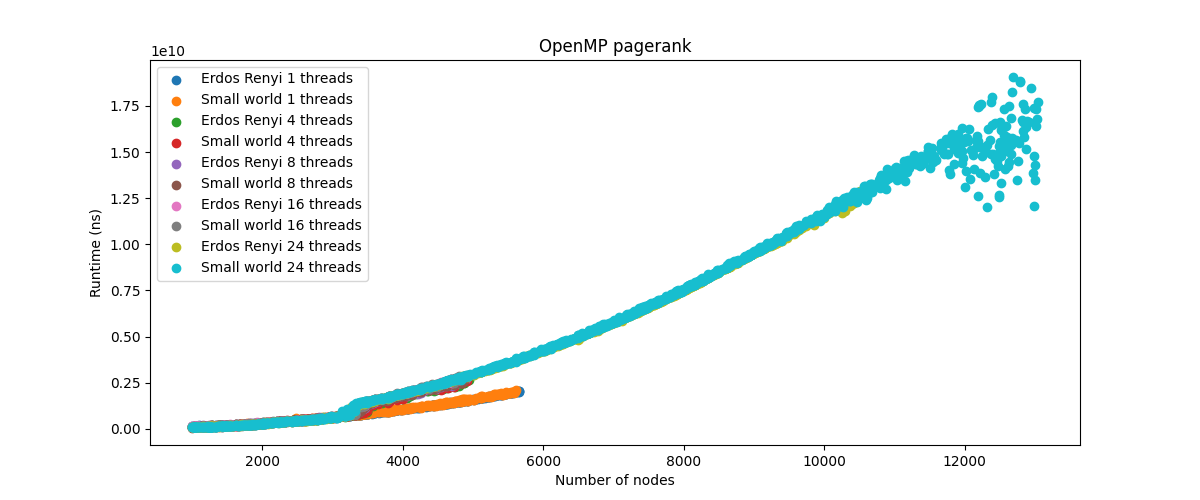

In [15]:
threads = [1, 4, 8, 16, 24]

plt.figure(figsize=(12, 5))
for thread in threads:
    pr_openmp_gnm = csv_to_df(f'pagerank/pr_openmp/gnm/output_{thread}.csv')
    pr_openmp_sw = csv_to_df(f'pagerank/pr_openmp/sw/output_{thread}.csv')

    # Take the average per graph
    pr_openmp_gnm = pr_openmp_gnm.groupby('graph').mean('runtime_ns').reset_index()
    pr_openmp_sw = pr_openmp_sw.groupby('graph').mean('runtime_ns').reset_index()

    # For each graph, get the predicted runtime using G.SIZE_VERTS and G.SIZE_EDGES
    # bfs_naive_gnm['predicted_time'] = bfs_naive_gnm.apply(lambda x: bfs_model(hardware_DAS6, x['G.SIZE_VERTS']), axis=1)

    # Plot with runtime on y axis and number of nodes on x axis
    plt.scatter(pr_openmp_gnm['G.SIZE_VERTS'], pr_openmp_gnm['runtime_ns'], label=f'Erdos Renyi {thread} thread{'s' if threads != 1 else ''}')
    plt.scatter(pr_openmp_sw['G.SIZE_VERTS'], pr_openmp_sw['runtime_ns'], label=f'Small world {thread} thread{'s' if threads != 1 else ''}')

plot("OpenMP pagerank", "Number of nodes", "Runtime (ns)")